**Prediction of Product Sales**

Peter Tran

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance

## saving variables for next lesson/notebook
import joblib

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',50)

import warnings
warnings.filterwarnings('ignore')

In [2]:
sales_df = pd.read_csv("Data/sales_predictions_2023.csv")
sales_df.info()
sales_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Clean Data

## Rows and Columns

In [3]:
sales_df.shape

(8523, 12)

## Datatypes

In [4]:
sales_df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

## Duplicates

In [5]:
sales_df.duplicated().sum()

0

## Missing Values

In [6]:
sales_df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

### Clean Missing "Outlet_Size"

In [7]:
pd.unique(sales_df["Outlet_Size"])

array(['Medium', nan, 'High', 'Small'], dtype=object)

- Outlet Size has very broad categories, so, because they're not very unique, we should keep this data.

In [8]:
sales_df.groupby(["Outlet_Type","Outlet_Location_Type", "Outlet_Size"], dropna=False)["Outlet_Size"].count()

Outlet_Type        Outlet_Location_Type  Outlet_Size
Grocery Store      Tier 1                Small          528
                   Tier 3                NaN              0
Supermarket Type1  Tier 1                Medium         930
                                         Small          930
                   Tier 2                Small          930
                                         NaN              0
                   Tier 3                High           932
Supermarket Type2  Tier 3                Medium         928
Supermarket Type3  Tier 3                Medium         935
Name: Outlet_Size, dtype: int64

- Looks like only **Grocery Store**, **Tier 3** and **Supermarket Type1**, **Tier 2** have missing values.

- We'll create a new category for these values called "Missing".


In [9]:
sales_df["Outlet_Size"].fillna("Missing", inplace=True)

- Check missing values sum

In [10]:
sales_df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [11]:
sales_df.groupby(["Outlet_Type", "Outlet_Location_Type", "Outlet_Size"])["Outlet_Size"].count()

Outlet_Type        Outlet_Location_Type  Outlet_Size
Grocery Store      Tier 1                Small           528
                   Tier 3                Missing         555
Supermarket Type1  Tier 1                Medium          930
                                         Small           930
                   Tier 2                Missing        1855
                                         Small           930
                   Tier 3                High            932
Supermarket Type2  Tier 3                Medium          928
Supermarket Type3  Tier 3                Medium          935
Name: Outlet_Size, dtype: int64

### Clean Missing "Item_Weight"

In [12]:
pd.unique(sales_df["Item_Weight"]).shape

(416,)

- "Item_Weight" seems to be general enough to keep at only 416 unique items.

In [13]:
sales_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Missing,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [14]:
sales_df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

- Because "Item_Weight" is a numerical value, we should be able to use mean, median, or mode to impute values.
- We'll use median

In [15]:
median_num = sales_df["Item_Weight"].median()

sales_df["Item_Weight"].fillna(median_num, inplace=True)

In [16]:
pd.set_option("display.max_rows", 20)
sales_df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## Fix of Inconsistent Data in Category

**Item_Fat_Content**

In [17]:
pd.unique(sales_df["Item_Fat_Content"])

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [18]:
sales_df["Item_Fat_Content"] = sales_df["Item_Fat_Content"].replace(["low fat", "LF"], "Low Fat")

In [19]:
pd.unique(sales_df["Item_Fat_Content"])

array(['Low Fat', 'Regular', 'reg'], dtype=object)

In [20]:
sales_df["Item_Fat_Content"] = sales_df["Item_Fat_Content"].replace("reg", "Regular")

In [21]:
pd.unique(sales_df["Item_Fat_Content"])

array(['Low Fat', 'Regular'], dtype=object)

**Item Type**

- Imported numpy to then sort the unique list to better see if any categories were inconsistent

In [22]:
import numpy as np

a = pd.unique(sales_df["Item_Type"])
np.sort(a)

array(['Baking Goods', 'Breads', 'Breakfast', 'Canned', 'Dairy',
       'Frozen Foods', 'Fruits and Vegetables', 'Hard Drinks',
       'Health and Hygiene', 'Household', 'Meat', 'Others', 'Seafood',
       'Snack Foods', 'Soft Drinks', 'Starchy Foods'], dtype=object)

**Outlet Identifier**

In [23]:
np.sort(pd.unique(sales_df["Outlet_Identifier"]))

array(['OUT010', 'OUT013', 'OUT017', 'OUT018', 'OUT019', 'OUT027',
       'OUT035', 'OUT045', 'OUT046', 'OUT049'], dtype=object)

**Outlet Size**

In [24]:
pd.unique(sales_df["Outlet_Size"])

array(['Medium', 'Missing', 'High', 'Small'], dtype=object)

**Outlet Location Type**

In [25]:
pd.unique(sales_df["Outlet_Location_Type"])

array(['Tier 1', 'Tier 3', 'Tier 2'], dtype=object)

**Outlet Type**

In [26]:
pd.unique(sales_df["Outlet_Type"])

array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
       'Supermarket Type3'], dtype=object)

## Summary Statistics for Numerical Columns

In [27]:
sales_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Missing,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


**Item Weight**

In [28]:
round(sales_df["Item_Weight"].describe(), 2)

count    8523.00
mean       12.81
std         4.23
min         4.56
25%         9.31
50%        12.60
75%        16.00
max        21.35
Name: Item_Weight, dtype: float64

**Item Visibility**

In [29]:
sales_df["Item_Visibility"].describe()

count    8523.000000
mean        0.066132
std         0.051598
min         0.000000
25%         0.026989
50%         0.053931
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64

**Item MRP**

In [30]:
round(sales_df["Item_MRP"].describe(), 2)

count    8523.00
mean      140.99
std        62.28
min        31.29
25%        93.83
50%       143.01
75%       185.64
max       266.89
Name: Item_MRP, dtype: float64

**Outlet Establishment Year**

In [31]:
round(sales_df["Outlet_Establishment_Year"].describe(), 0)

count    8523.0
mean     1998.0
std         8.0
min      1985.0
25%      1987.0
50%      1999.0
75%      2004.0
max      2009.0
Name: Outlet_Establishment_Year, dtype: float64

**Item Outlet Sales**

In [32]:
round(sales_df["Item_Outlet_Sales"].describe(), 2)

count     8523.00
mean      2181.29
std       1706.50
min         33.29
25%        834.25
50%       1794.33
75%       3101.30
max      13086.96
Name: Item_Outlet_Sales, dtype: float64

# Exploratory Data Analysis


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
sales_df.head(1)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.138


## Histogram

- Show the distribution of 'Item_Outlet_Sales' as a dollar and the number of stores.

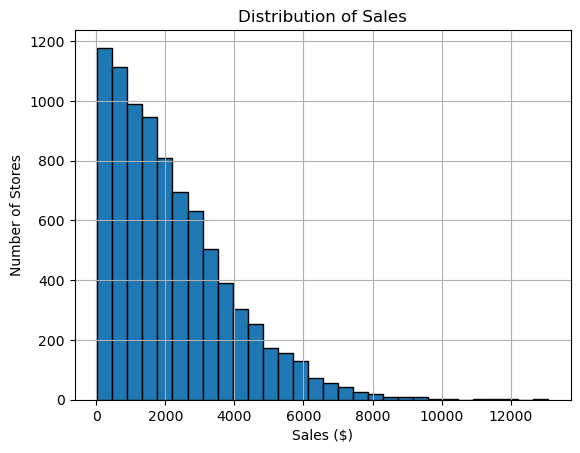

In [35]:
ax = sales_df['Item_Outlet_Sales'].hist(bins=30, edgecolor='black')
ax.set_title("Distribution of Sales")
ax.set_xlabel("Sales ($)")
ax.set_ylabel("Number of Stores");

In [36]:
len(sales_df)

8523

In [37]:
len(sales_df[sales_df['Item_Outlet_Sales'] < 2000])

4667

- A significant portion of stores make less than \$2000.
- It looks like a little more than half of all stores make less than \$2000.

## Boxplot
- We'll compare 3 different columns of data with **Item_Outlet_Sales** to better understand how and where the most sales are coming from.

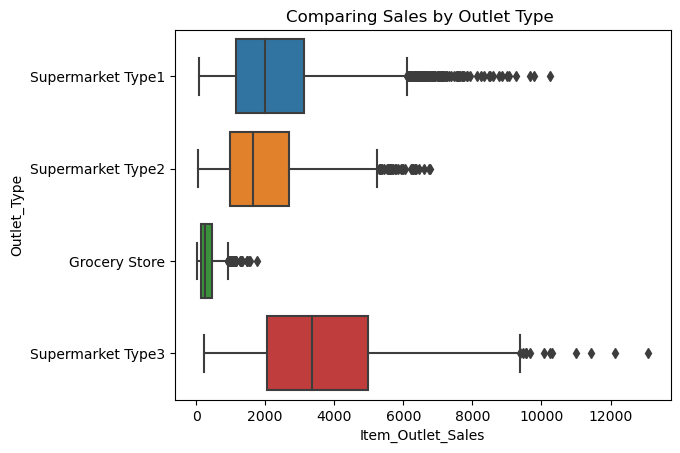

In [38]:
ax = sns.boxplot(x='Item_Outlet_Sales', y='Outlet_Type', data=sales_df)
ax.set_title("Comparing Sales by Outlet Type ");

- From this chart, we can see that **Supermarket Type3** has the better distribution of sales.
  - It has a higher median number of sales
  - It's IQR is larger and in a higher position
  - And it's max is higher
  

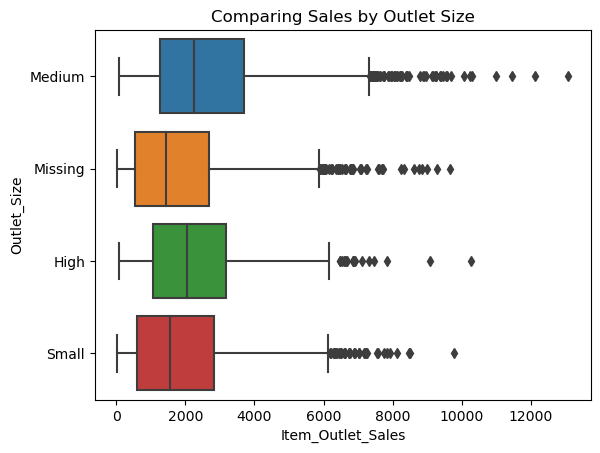

In [39]:
ax = sns.boxplot(x='Item_Outlet_Sales', y='Outlet_Size', data=sales_df)
ax.set_title("Comparing Sales by Outlet Size");

- From this chart, we can see that **Medium** sized stores have the more sales.
  - The median is higher
  - The IQR is larger and in a higher position
  - And the max is higher as well

- Though we do have a "Missing" category, it looks like it matches up with "Small" outlet size.

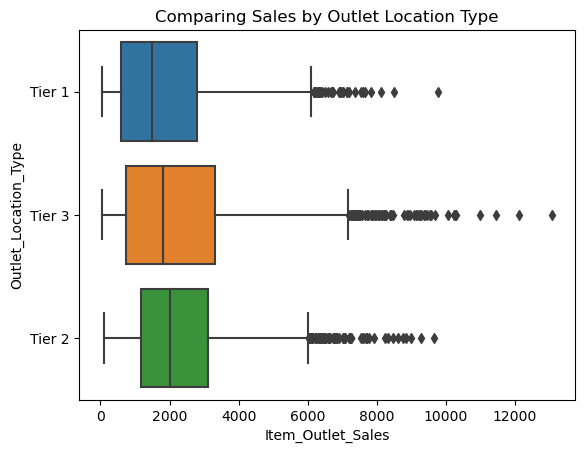

In [40]:
ax = sns.boxplot(x='Item_Outlet_Sales', y='Outlet_Location_Type', data=sales_df)
ax.set_title("Comparing Sales by Outlet Location Type");

- Though these Boxplots are more similar, it looks like **Tier 3** could be the better "Outlet_Location_Type" by sales.
  - Though the median is lower than **Tier 2**, it's only by a nominal amount
  - The IQR is larger and in a comparably equal or higher range than **Tier 1** or **Tier 2**
  - The max is higher as well

- Taking these three charts together, it looks like the most sales come from stores that are **Supermarket Type3**, **Medium Size**, and **Tier 3**.

## Heatmap
- Here we'll see how pairs of data columns relate to each other.

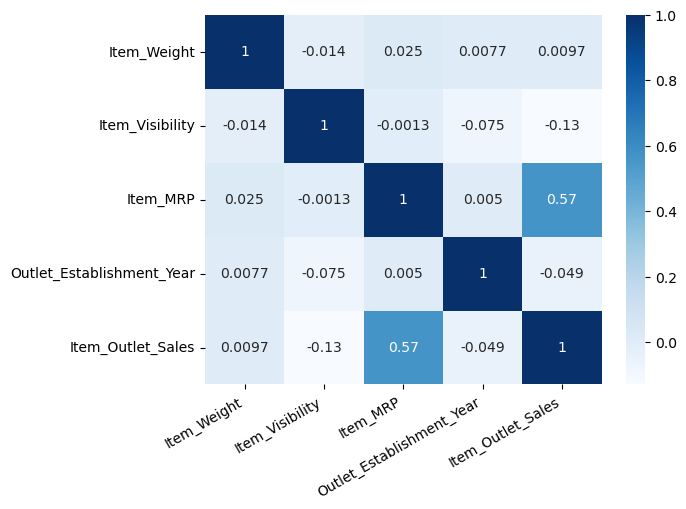

In [41]:
fig, ax = plt.subplots()
corr = sales_df.corr()
sns.heatmap(corr, cmap='Blues', annot=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, horizontalalignment='right');

- There is a moderate correlation between **Item_MRP** and **Item_Outlet_Sales**
- Seems to be the higher the price of the item, the higher the sales return.

# Explanatory Data Analysis

## Item MRP by Item Outlet Sales
- **Item_MRP** and **Item_Outlet_Sales** have a moderate positive correlation of 0.57

In [42]:
sales_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Missing,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


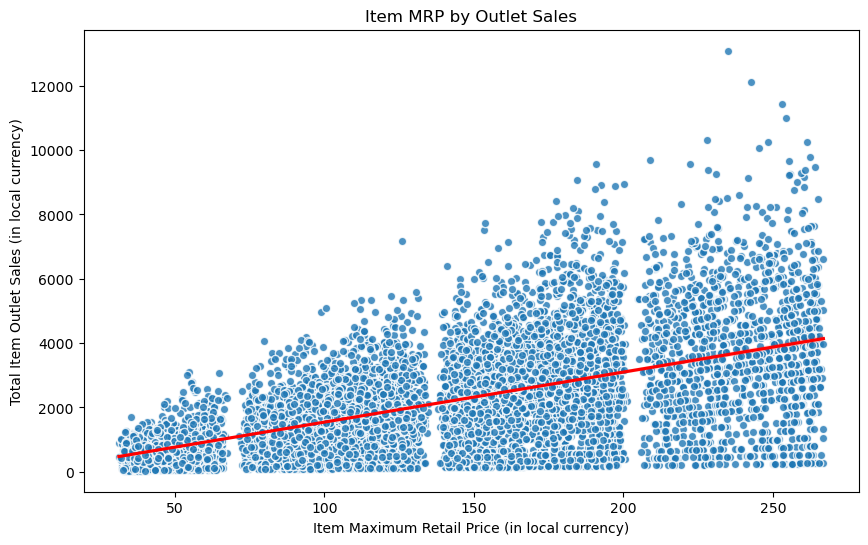

In [43]:

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.regplot(data=sales_df, x='Item_MRP', y='Item_Outlet_Sales', line_kws={'color':'red'}, scatter_kws={'edgecolors':'white'})

ax.set_title("Item MRP by Outlet Sales")
ax.set_xlabel("Item Maximum Retail Price (in local currency)")
ax.set_ylabel("Total Item Outlet Sales (in local currency)");

- Here we can see that as the price of the item goes up, the total return goes up as well
  - Less of those products are sold, but the higher price makes up the difference

## Sales by Item Type

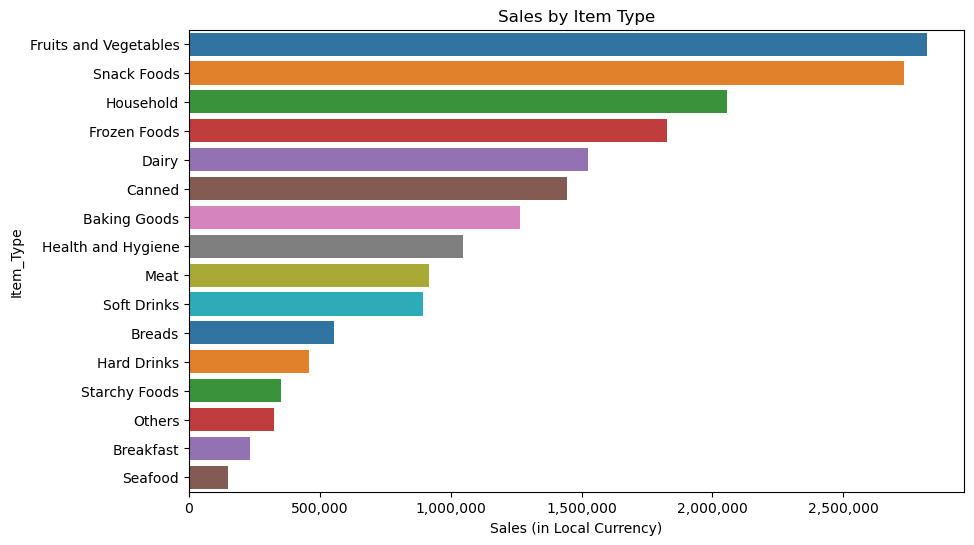

In [44]:
import matplotlib.ticker as ticker

df_sorted = sales_df.groupby('Item_Type')['Item_Outlet_Sales'].sum().reset_index().sort_values('Item_Outlet_Sales', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=df_sorted, x='Item_Outlet_Sales', y='Item_Type', order=df_sorted['Item_Type'], palette='tab10')
ax.set_title('Sales by Item Type')
ax.set_xlabel('Sales (in Local Currency)')
price_fmt = ticker.StrMethodFormatter("{x:,.0f}")
ax.xaxis.set_major_formatter(price_fmt);

- We can see that 'Fruits and Vegetables' has the most sales followed closely by 'Snack Foods'

## Categorical Plot Comparing Outlet Type, Size, and Location Type by Sales

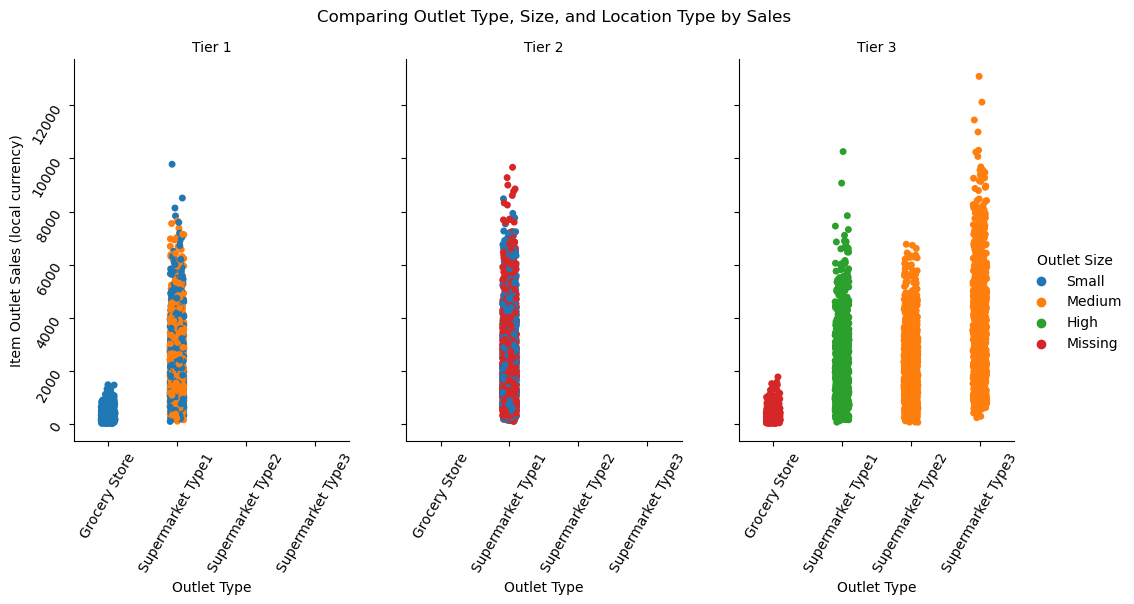

In [45]:

g = sns.catplot(data=sales_df, x='Outlet_Type', y='Item_Outlet_Sales', 
                col='Outlet_Location_Type', 
                hue='Outlet_Size',
                aspect=.7, 
                order=['Grocery Store', 'Supermarket Type1', 'Supermarket Type2', 'Supermarket Type3'],
                hue_order=['Small', 'Medium', 'High', 'Missing'],
                col_order=['Tier 1', 'Tier 2', 'Tier 3'])
g.tick_params(rotation=60)
g.set_axis_labels("Outlet Type", "Item Outlet Sales (local currency)")
g.set_titles("{col_name}")
g._legend.set_title("Outlet Size")
g.fig.subplots_adjust(top=.88)
g.fig.suptitle('Comparing Outlet Type, Size, and Location Type by Sales');

- This plot is broken up into the *3 Tiers* of **Outlet_Location_Type** with a hue of **Outlet_Size**
- It shows the **Outlet_Type** by **Item_Outlet_Sales**
- We can see that there are much more *Medium* stores
- We can also see that *Tier 3* stores have the most variety of **Outlet_Type**
- We can then see that *Supermarket Type1* is in every *Tier* and has all **Outlet_Sizes** including the *Missing* ones

# Machine Learning

- Will use Machine Learning to make predictions about future sales

## Preprocess

- For this process I'll use the original, uncleaned sales prediction dataset to prevent data leakage

### Load Data

In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display='diagram')

In [47]:
df_original = pd.read_csv('Data/sales_predictions_2023.csv')
df = df_original.copy()
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### Drop Duplicates and Fix Inconsistencies in Categorical Data

**Duplicates**

In [49]:
df.duplicated().sum()

0

**Object Inconsistencies**

In [50]:
object_type = df.dtypes[df.dtypes == 'object']
for i in object_type.index:
  print(i, '---')
  print(df[i].unique())
  print("")

Item_Identifier ---
['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']

Item_Fat_Content ---
['Low Fat' 'Regular' 'low fat' 'LF' 'reg']

Item_Type ---
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']

Outlet_Identifier ---
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']

Outlet_Size ---
['Medium' nan 'High' 'Small']

Outlet_Location_Type ---
['Tier 1' 'Tier 3' 'Tier 2']

Outlet_Type ---
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']



In [51]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'})

In [52]:
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

**Numeric Inconsistencies**

In [53]:
num_types = df.dtypes[df.dtypes != 'object']
num_types

Item_Weight                  float64
Item_Visibility              float64
Item_MRP                     float64
Outlet_Establishment_Year      int64
Item_Outlet_Sales            float64
dtype: object

In [54]:
df[num_types.index].head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,9.30,0.016047,249.8092,1999,3735.1380
1,5.92,0.019278,48.2692,2009,443.4228
2,17.50,0.016760,141.6180,1999,2097.2700
3,19.20,0.000000,182.0950,1998,732.3800
4,8.93,0.000000,53.8614,1987,994.7052


In [55]:
df['Outlet_Establishment_Year'] = df['Outlet_Establishment_Year'].astype('object')

In [56]:
df['Outlet_Establishment_Year'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 8523 entries, 0 to 8522
Series name: Outlet_Establishment_Year
Non-Null Count  Dtype 
--------------  ----- 
8523 non-null   object
dtypes: object(1)
memory usage: 66.7+ KB


### Explore Data for Missing Values

In [57]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [58]:
df[['Item_Weight', 'Outlet_Size']].dtypes

Item_Weight    float64
Outlet_Size     object
dtype: object

- **There are missing values we'll need to impute:**

  - Will use *median* for 'Item_Weight' to account for any outliers
  - Will use *most_frequent* for 'Outlet_Size' since it's nominal

### Identify Features(X) and Target(Y)

- Target: 'Item_Outlet_Sales'
- Features: the rest of the relevant variables

In [59]:
X = df.drop(columns=['Item_Outlet_Sales', 'Item_Identifier'])
y = df['Item_Outlet_Sales']

### Train/Test Split

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Preprocessing Object

#### Instantiate Column Selectors

In [61]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

#### Instantiate Transformers

In [62]:
# Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
median_imputer = SimpleImputer(strategy='median')
# Scaler
scaler = StandardScaler()
# OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

#### Instantiate Pipeline

In [63]:
num_pipe = make_pipeline(median_imputer, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [64]:
cat_pipe = make_pipeline(freq_imputer, ohe)
cat_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

#### Instantiate ColumnTransformer

In [65]:
num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)
# ColumnTransformer
preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder='passthrough', verbose_feature_names_out=False)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x16c391d30>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x16c391ca0>)],
                  verbose_feature_names_out=False)

#### Transform Data

In [66]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x16c391d30>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x16c391ca0>)],
                  verbose_feature_names_out=False)

In [67]:
# transform train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

#### Inspect Result

##### View Data Numpy Array

In [68]:
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
print(X_train_processed)
X_train_processed.shape

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (6392, 50)


[[ 0.82748547 -0.71277507  1.82810922 ...  0.          1.
   0.        ]
 [ 0.56664432 -1.29105225  0.60336888 ...  0.          1.
   0.        ]
 [-0.12102782  1.81331864  0.24454056 ...  1.          0.
   0.        ]
 ...
 [ 1.12389588 -0.92052713  1.52302674 ...  1.          0.
   0.        ]
 [ 1.77599877 -0.2277552  -0.38377708 ...  1.          0.
   0.        ]
 [ 0.82748547 -0.95867683 -0.73836105 ...  1.          0.
   0.        ]]


(6392, 50)

##### View Pandas DataFrame

In [69]:
X_train_processed_df = pd.DataFrame(X_train_processed, 
                                    columns = preprocessor.get_feature_names_out())
X_test_processed_df = pd.DataFrame(X_test_processed,
                                   columns = preprocessor.get_feature_names_out())

In [70]:
X_train_processed_df

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Establishment_Year_1985,Outlet_Establishment_Year_1987,Outlet_Establishment_Year_1997,Outlet_Establishment_Year_1998,Outlet_Establishment_Year_1999,Outlet_Establishment_Year_2002,Outlet_Establishment_Year_2004,Outlet_Establishment_Year_2007,Outlet_Establishment_Year_2009,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,0.827485,-0.712775,1.828109,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.566644,-1.291052,0.603369,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.121028,1.813319,0.244541,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.158464,-1.004931,-0.952591,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.538870,-0.965484,-0.336460,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,-0.821742,4.309657,-0.044657,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
6388,0.649639,1.008625,-1.058907,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6389,1.123896,-0.920527,1.523027,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6390,1.775999,-0.227755,-0.383777,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [71]:
print(f"The feature type for all features is: \n\n{X_train_processed_df.dtypes.unique()}")

The feature type for all features is: 

[dtype('float64')]


# Regression Models

- We will be using the Machine Learning object 'X_train_processed'

## Import Libraries

In [72]:
## Pandas
import pandas as pd
## Numpy
import numpy as np

## Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

## Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor 

## Regression Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## Set global scikit-learn configuration 
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

In [73]:
def eval_regression(y_true, y_pred, name='model'):
  """Takes true targets and predictions from a regression model and prints
  MAE, MSE, RMSE, AND R2 scores
  Set 'name' to name of model and 'train' or 'test' as appropriate"""
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)

  return(f'{name} Scores\nMAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

## Baseline Model

In [74]:
# instantiate DummyRegressor object using 'mean'
dummy_model = DummyRegressor(strategy='mean')
# fit on X_train processed data and y_train
dummy_model.fit(X_train_processed, y_train)
# predictions
dummy_train_predict = dummy_model.predict(X_train_processed)
dummy_test_predict = dummy_model.predict(X_test_processed)

In [75]:
# run custom function for train
print(eval_regression(y_train, dummy_train_predict, name='Baseline Train'))
# run custom function for test
print(eval_regression(y_test, dummy_test_predict, name='Baseline Test'))

Baseline Train Scores
MAE: 1,360.2184 
MSE: 2,959,455.7045 
RMSE: 1,720.3069 
R2: 0.0000

Baseline Test Scores
MAE: 1,326.1210 
MSE: 2,772,144.4627 
RMSE: 1,664.9758 
R2: -0.0048



## Linear Regression Model

In [76]:
X_train_processed

array([[ 0.82748547, -0.71277507,  1.82810922, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.56664432, -1.29105225,  0.60336888, ...,  0.        ,
         1.        ,  0.        ],
       [-0.12102782,  1.81331864,  0.24454056, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.12389588, -0.92052713,  1.52302674, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.77599877, -0.2277552 , -0.38377708, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82748547, -0.95867683, -0.73836105, ...,  1.        ,
         0.        ,  0.        ]])

In [77]:
# Instantiate LinearRegression
lin_reg = LinearRegression()

# fit
lin_reg.fit(X_train_processed, y_train)

LinearRegression()

### Linear Regression DataFrames

In [78]:
# instantiate Prediction object
train_predict = lin_reg.predict(X_train_processed)

In [79]:
train_predict_df = X_train.copy()
train_predict_df['True Sales Price'] = y_train
train_predict_df['Predicted Sales Price'] = train_predict
train_predict_df['Error'] = train_predict - y_train
train_predict_df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,True Sales Price,Predicted Sales Price,Error
4776,16.350,Low Fat,0.029565,Household,256.4646,OUT018,2009,Medium,Tier 3,Supermarket Type2,515.3292,3811.5,3296.1708
7510,15.250,Regular,0.000000,Snack Foods,179.7660,OUT018,2009,Medium,Tier 3,Supermarket Type2,3056.0220,2655.5,-400.5220
5828,12.350,Regular,0.158716,Meat,157.2946,OUT049,1999,Medium,Tier 1,Supermarket Type1,1577.9460,2609.0,1031.0540
5327,7.975,Low Fat,0.014628,Baking Goods,82.3250,OUT035,2004,Small,Tier 2,Supermarket Type1,1331.6000,1484.0,152.4000
4810,19.350,Low Fat,0.016645,Frozen Foods,120.9098,OUT045,2002,NaN,Tier 2,Supermarket Type1,1687.1372,1874.0,186.8628


In [80]:
test_predict = lin_reg.predict(X_test_processed)

In [81]:
test_predict_df = X_test.copy()
test_predict_df['True Sales Price'] = y_test
test_predict_df['Predicted Sales Price'] = test_predict
test_predict_df['Error'] = test_predict - y_test
test_predict_df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,True Sales Price,Predicted Sales Price,Error
7503,14.300,Low Fat,0.026300,Frozen Foods,79.4302,OUT013,1987,High,Tier 3,Supermarket Type1,1743.0644,1360.5,-382.5644
2957,7.930,Low Fat,0.071136,Health and Hygiene,42.7086,OUT046,1997,Small,Tier 1,Supermarket Type1,356.8688,717.5,360.6312
7031,14.500,Regular,0.041313,Canned,42.0454,OUT049,1999,Medium,Tier 1,Supermarket Type1,377.5086,882.5,504.9914
1084,NaN,Regular,0.044767,Soft Drinks,173.7054,OUT027,1985,Medium,Tier 3,Supermarket Type3,5778.4782,4233.5,-1544.9782
856,10.195,Regular,0.012456,Meat,197.5110,OUT035,2004,Small,Tier 2,Supermarket Type1,2356.9320,3343.0,986.0680


### Metrics

In [82]:

lin_train_eval = eval_regression(y_train, train_predict, name='Linear Regression Train')
print(lin_train_eval)

lin_test_eval = eval_regression(y_test, test_predict, name='Linear Regression Test')
print(lin_test_eval)

Linear Regression Train Scores
MAE: 847.1184 
MSE: 1,297,559.0334 
RMSE: 1,139.1045 
R2: 0.5616

Linear Regression Test Scores
MAE: 804.1062 
MSE: 1,194,363.1330 
RMSE: 1,092.8692 
R2: 0.5671



## Decision Tree Model

In [83]:
# instantiate DecisionTreeRegressor object
dec_tree = DecisionTreeRegressor(random_state=42)
# fit
dec_tree.fit(X_train_processed, y_train)
# predictions
dec_train_predict = dec_tree.predict(X_train_processed)
dec_test_predict = dec_tree.predict(X_test_processed)

### Evaluate Default R2 Score

In [84]:
dec_train_score = dec_tree.score(X_train_processed, y_train)
dec_test_score = dec_tree.score(X_test_processed, y_test)

print(dec_train_score)
print(dec_test_score)

1.0
0.12909682111027831


### Tune Decision Tree

In [85]:
dec_tree.get_depth()

44

In [86]:
depths = range(2,45)
scores = pd.DataFrame(index=depths, columns=['Train', 'Test'])

for depth in depths:
  dec_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
  dec_tree.fit(X_train_processed, y_train)
  scores.loc[depth, 'Train'] = dec_tree.score(X_train_processed, y_train)
  scores.loc[depth, 'Test'] = dec_tree.score(X_test_processed, y_test)

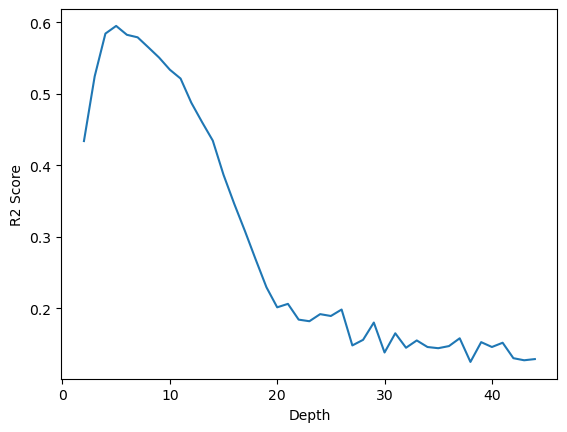

In [87]:
import matplotlib.pyplot as plt

plt.plot(depths, scores['Test'])
plt.xlabel('Depth')
plt.ylabel('R2 Score');

In [88]:
scores.sort_values(by='Test', ascending=False).head()

,Train,Test
5,0.603933,0.594709
4,0.582625,0.584005
6,0.615153,0.582307
7,0.626841,0.578772
8,0.643849,0.564725


#### Best Decision Tree
- `max_depth=5`

In [89]:
# instantiate best DecisionTreeRegressor
best_dec_tree = DecisionTreeRegressor(max_depth=5, random_state=42)
# fit
best_dec_tree.fit(X_train_processed, y_train)
# r2 scores
best_tree_train_score = best_dec_tree.score(X_train_processed, y_train)
best_tree_test_score = best_dec_tree.score(X_test_processed, y_test)

print(f'Best Training Decision Tree Score: {best_tree_train_score}')
print(f'Best Testing Decision Tree Score: {best_tree_test_score}')

Best Training Decision Tree Score: 0.603933236086491
Best Testing Decision Tree Score: 0.5947092601209935


### Metrics

In [90]:
dec_train_predict = best_dec_tree.predict(X_train_processed)
dec_test_predict = best_dec_tree.predict(X_test_processed)

In [91]:

dec_train_eval = eval_regression(y_train, dec_train_predict, name='Decision Tree Train')
print(dec_train_eval)

dec_test_eval = eval_regression(y_test, dec_test_predict, name='Decision Tree Test')
print(dec_test_eval)

Decision Tree Train Scores
MAE: 762.6399 
MSE: 1,172,142.0438 
RMSE: 1,082.6551 
R2: 0.6039

Decision Tree Test Scores
MAE: 738.3556 
MSE: 1,118,187.9463 
RMSE: 1,057.4441 
R2: 0.5947



## Model Analysis and Comparison

- Based off Test Model scores

### Metrics Scores

In [92]:
print(lin_test_eval)
print(dec_test_eval)

Linear Regression Test Scores
MAE: 804.1062 
MSE: 1,194,363.1330 
RMSE: 1,092.8692 
R2: 0.5671

Decision Tree Test Scores
MAE: 738.3556 
MSE: 1,118,187.9463 
RMSE: 1,057.4441 
R2: 0.5947



### Percentage of Error
- Mean Absolute Error compared with the average 'Item_Outlet_Sales'
- Will return a percentage of how much average error there is for each model using MAE

In [93]:
lin_test_mae = mean_absolute_error(y_test, test_predict)

(lin_test_mae / df['Item_Outlet_Sales'].mean()) * 100

36.86380781452415

In [94]:
dec_test_mae = mean_absolute_error(y_test, dec_test_predict)

(dec_test_mae / df['Item_Outlet_Sales'].mean()) * 100

33.849510553333

## Final Evaluation

The Decision Tree is the better model to use when predicting Item Sales.

From the Metrics Score, we can see that the Mean Absolute Error for the Decision Tree is lower by about 70 rupees. The Root Mean Squared Error is also lower for the Decision Tree, meaning that there are less outliers throwing off the weight of our model.

Looking at the Percentage of Error, we can also see that the Linear Regression model will be off, on average, by 36.87% while the Decision Tree will be off by 33.85%. We'll have less error with the Decision Tree.

I would also like to mention that the R-Squared score is better for the Decision Tree at 59.47%, compared to the Linear Regression score of 56.71%. This means that our Decision Tree model better fits the data. The trendline that we generate with this model will be a better representation of the true values.


# **Revisited Importances**

## Load Data/Libraries

In [95]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance

## saving variables
import joblib

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',50)

In [96]:
df = pd.read_csv('Data/sales_predictions_2023.csv')
df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


## Set Visualization Style

In [97]:
## Customization Options
plt.style.use(('ggplot','tableau-colorblind10'))
sns.set_context(context='notebook', font_scale= 1.2)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['figure.facecolor']='white'

## Clean Data

### Object Inconsistencies

In [98]:
object_type = df.dtypes[df.dtypes == 'object']
for i in object_type.index:
  print(i, '---')
  print(df[i].unique())
  print("")

Item_Identifier ---
['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']

Item_Fat_Content ---
['Low Fat' 'Regular' 'low fat' 'LF' 'reg']

Item_Type ---
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']

Outlet_Identifier ---
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']

Outlet_Size ---
['Medium' nan 'High' 'Small']

Outlet_Location_Type ---
['Tier 1' 'Tier 3' 'Tier 2']

Outlet_Type ---
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']



In [99]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'})
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

## Preprocess

In [100]:
df.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


In [101]:
X = df.drop(columns=['Item_Outlet_Sales', 'Item_Identifier'])
y = df['Item_Outlet_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

In [102]:
cat_select = make_column_selector(dtype_include='object')
cat_select(X_train)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [103]:
num_select = make_column_selector(dtype_include='number')
num_select(X_train)

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [104]:
for col in cat_select(X_train):
    print(f'{col}:\n{df[col].unique()}\n')

Item_Fat_Content:
['Low Fat' 'Regular']

Item_Type:
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']

Outlet_Identifier:
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']

Outlet_Size:
['Medium' nan 'High' 'Small']

Outlet_Location_Type:
['Tier 1' 'Tier 3' 'Tier 2']

Outlet_Type:
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']



In [105]:
cat_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='MISSING'),
                         OneHotEncoder(drop='first', sparse=False))

num_pipe = make_pipeline(SimpleImputer(strategy='median'))

In [106]:
preprocessor = make_column_transformer((cat_pipe, cat_select),
                                       (num_pipe, num_select),
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x16c0714c0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x16c071190>)],
                  verbose_feature_names_out=False)

In [107]:
preprocessor.fit(X_train)

feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Item_Fat_Content_Regular', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019',
       'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049', 'Outlet_Size_MISSING',
       'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3', 'Item_Weight', 'Item_V

In [108]:
X_train_df = pd.DataFrame(preprocessor.transform(X_train), columns=feature_names,
                          index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test), columns=feature_names,
                          index=X_test.index)

In [109]:
X_test_df.head(3)

,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
8077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,15.25,0.061531,132.2968,2007.0
2391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,17.85,0.044463,127.1020,1997.0
163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,7.27,0.071078,114.2518,1997.0


In [110]:
y_test.head(3)

8077    1696.4584
2391    2024.0320
163     2618.5914
Name: Item_Outlet_Sales, dtype: float64

## Custom Functions

In [111]:
def evaluate_regression(model, X_train=X_train_df,y_train=y_train, X_test=X_test_df, y_test=y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [112]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True, permutation=False, random_state=42,
                   X_train=X_train_df, y_train=y_train):
    
    r = permutation_importance(model, X_train, y_train, n_repeats =5, 
                                   random_state = random_state)
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
        
    if permutation==True:        
        importances = pd.Series(r['importances_mean'],index=X_train.columns,
                           name = 'permutation importance')
    
        # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [113]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

In [114]:
def plot_importance_color(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None, color_rest='#006ba4', color_top='green',
                          top_important=5, ax=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)
        
    else:
        highlight_feats = importances.sort_values(ascending=True).tail(top_important).index
        colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}        
        colors = plot_vals.index.map(colors_dict)
        
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [115]:
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    coeffs['intercept'] = lin_reg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

In [116]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5), 
                intercept=False, intercept_name="intercept", 
                annotate=False, ha='left', va='center', size=12, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')    

    
    if annotate == True:
            for bar in ax.patches:
                ## calculate center of bar
                bar_ax = bar.get_y() + bar.get_height() / 2
                ## get the value to annotate
                val = bar.get_width()

                # handle negative values by setting them to position 0
                if val < 0:
                    val_pos = 0
                else:
                    val_pos = val        
        
                # ha and va stand for the horizontal and vertical alignment
                ax.annotate(f"{val:.3f}", (val_pos,bar_ax),
                            ha=ha, va=va, size=size,
                            xytext=xytext, textcoords=textcoords)
    return ax

## Linear Regression Coefficient Visualization and Interpretation

In [117]:
linreg = LinearRegression()

linreg.fit(X_train_df, y_train)
evaluate_regression(linreg)

Training Data:	R^2= 0.56	RMSE= 1114.98
Test Data:	R^2= 0.56	RMSE= 1164.41


### Extract Coefficients and Visualize

In [118]:
coeff = get_coeffs_linreg(linreg)
coeff

Outlet_Size_MISSING               -698.975078
Outlet_Identifier_OUT019          -634.173663
Outlet_Identifier_OUT049          -382.139994
Item_Visibility                   -276.611557
Outlet_Size_Small                 -221.749671
                                     ...     
Outlet_Size_Medium                 692.827329
Outlet_Identifier_OUT027           900.794410
Outlet_Type_Supermarket Type3      900.794410
Outlet_Type_Supermarket Type1      925.321714
intercept                        18352.242938
Length: 38, dtype: float64

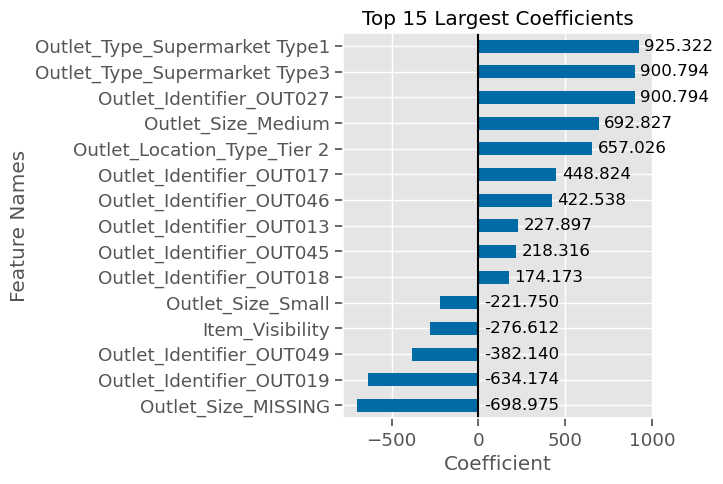

In [119]:
plot_coeffs(coeff, top_n=15, annotate=True);

### Interpret Top 3 Most Impactful Features Models

- 'Outlet_Type_Supermarket Type1':
    - If Outlet_type Supermarket Type 1"" == 1, then the product is sold at that type of store and the product will generate that much more revenue.
    
    
- 'Outlet_Identifier_OUT027':
    - If the Outlet Identifier is OUT027, this also increases our value of interest. (like sales or customer visits) but by about 901 units. So, it has the second strongest effect.
    
    
- 'Outlet_Type_Supermarket Type3':
    - If the Outlet Type is Supermarket Type 3, increase our value of interest by about 900.794 units, just like the effect of the supermarket with ID 'OUT027'. So these two features share the same level of effect, which make them equally important in our analysis. 
    
    
#### - The most impactful features are object type
 -  The different types of supermarkets and their unique IDs, and understanding the city and its people better, we can make smarter guesses about how well each supermarket might do in terms of sales.


## RandomForest Default Feature Importance

In [120]:
cat_pipe_rf = make_pipeline(SimpleImputer(strategy='constant', fill_value='MISSING'),
                            OneHotEncoder(drop='if_binary', sparse=False))

In [121]:
preprocessor_rf = make_column_transformer((cat_pipe_rf, cat_select), 
                                        (num_pipe, num_select),
                                        verbose_feature_names_out=False)
preprocessor_rf

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x16c0714c0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x16c071190>)],
                  verbose_feature_names_out=False)

In [122]:
preprocessor_rf.fit(X_train)

feature_names_rf = preprocessor_rf.get_feature_names_out()
feature_names_rf

array(['Item_Fat_Content_Regular', 'Item_Type_Baking Goods',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household',
       'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood',
       'Item_Type_Snack Foods', 'Item_Type_Soft Drinks',
       'Item_Type_Starchy Foods', 'Outlet_Identifier_OUT010',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019',
       'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049', 'Outlet_Size_High',
       'Outlet_Size_MISSING', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Gro

In [123]:
X_train_rf = pd.DataFrame(preprocessor_rf.transform(X_train), columns=feature_names_rf,
                          index=X_train.index)
X_test_rf = pd.DataFrame(preprocessor_rf.transform(X_test), columns=feature_names_rf,
                          index=X_test.index)
X_test_rf.head(3)

,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_High,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
8077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,15.25,0.061531,132.2968,2007.0
2391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,17.85,0.044463,127.1020,1997.0
163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,7.27,0.071078,114.2518,1997.0


In [124]:
y_test.head(3)

8077    1696.4584
2391    2024.0320
163     2618.5914
Name: Item_Outlet_Sales, dtype: float64

In [125]:
print(len(X_test_rf.columns))
len(X_test_df.columns)

42


37

In [126]:
rf = RandomForestRegressor(random_state=SEED)

rf.fit(X_train_rf, y_train)
evaluate_regression(rf, X_train=X_train_rf, X_test=X_test_rf)

Training Data:	R^2= 0.94	RMSE= 423.36
Test Data:	R^2= 0.56	RMSE= 1163.09


### Extract and Evaluate Feature Importance

In [127]:
importances_def = get_importances(rf, feature_names=None,name='Feature Importance',
                   sort=True, ascending=False, permutation=False, random_state=SEED,
                   X_train=X_train_rf, y_train=y_train)
importances_def

Item_MRP                         0.444427
Outlet_Type_Grocery Store        0.196758
Item_Visibility                  0.097388
Item_Weight                      0.053951
Outlet_Identifier_OUT027         0.030823
                                   ...   
Item_Type_Seafood                0.001377
Outlet_Identifier_OUT018         0.001028
Outlet_Type_Supermarket Type2    0.000963
Outlet_Identifier_OUT019         0.000013
Outlet_Identifier_OUT010         0.000010
Name: Feature Importance, Length: 42, dtype: float64

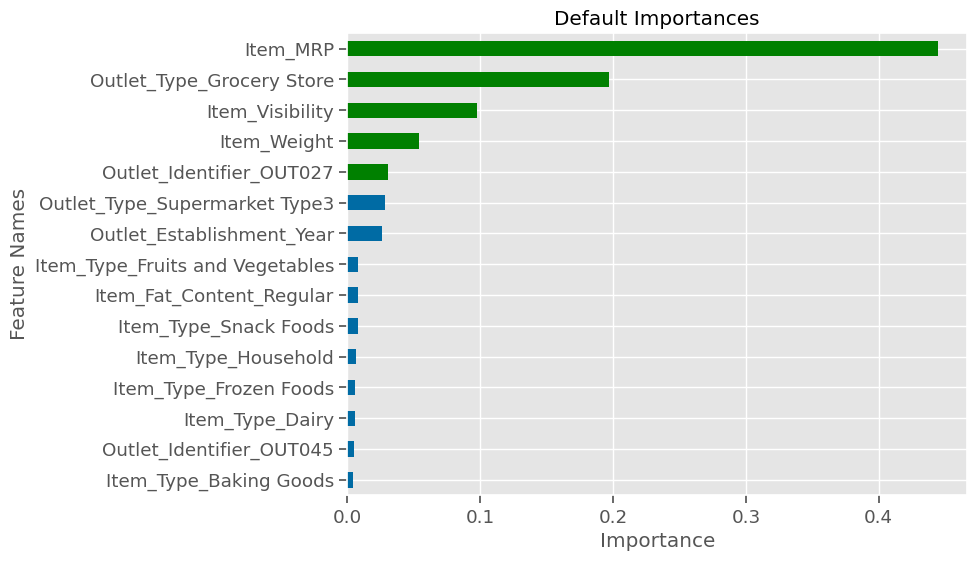

In [128]:
plot_importance_color(importances_def, top_n=15,  figsize=(8,6), 
                          color_dict=None, color_rest='#006ba4', color_top='green',
                          top_important=5, ax=None)
plt.title('Default Importances');

- **Top 5 most important**
    - 'Item_MRP'
    - 'Outlet_Type_Grocery Store'
    - 'Item_Visibility'
    - 'Item_Weight'
    - 'Outlet_Identifier_OUT027'

## RandomForest Permutation Feature Importance

In [129]:
importances_perm = get_importances(rf, feature_names=None,name='Feature Importance',
                   sort=True, ascending=False, permutation=True, random_state=SEED,
                   X_train=X_train_rf, y_train=y_train)
importances_perm

Item_MRP                     1.103050
Outlet_Type_Grocery Store    0.455908
Item_Visibility              0.179307
Item_Weight                  0.101938
Outlet_Identifier_OUT027     0.057571
                               ...   
Outlet_Size_High             0.001900
Item_Type_Others             0.001443
Item_Type_Seafood            0.001337
Outlet_Identifier_OUT019     0.000016
Outlet_Identifier_OUT010     0.000014
Name: permutation importance, Length: 42, dtype: float64

In [130]:
color_top5 = get_color_dict(importances_def, color_rest='#006ba4' , color_top='green',
                    top_n=5)

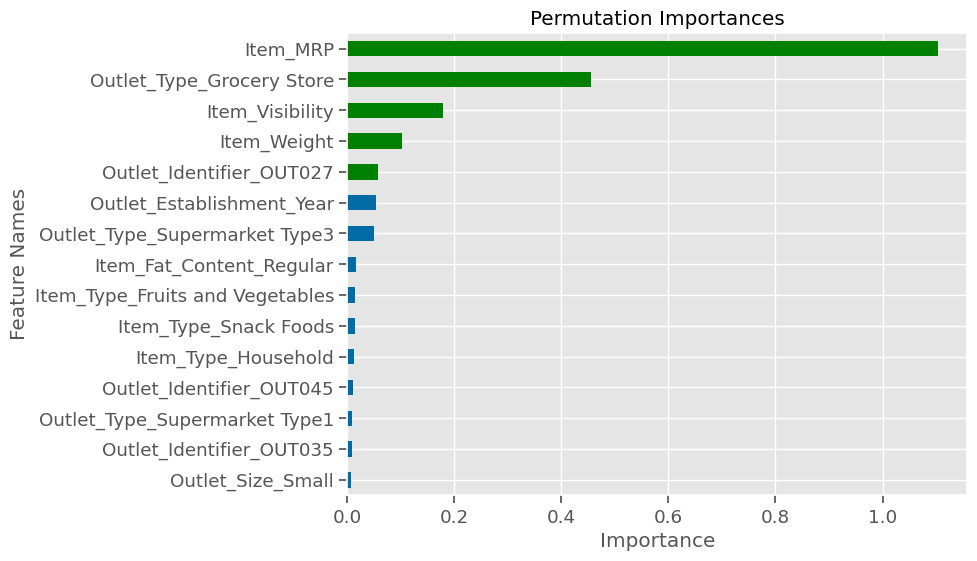

In [131]:
plot_importance_color(importances_perm, top_n=15,  figsize=(8,6), 
                          color_dict=color_top5, color_rest='#006ba4', color_top='green',
                          top_important=5)

plt.title('Permutation Importances');

- Top 5 Most Important:
    - 'Item_MRP'
    - 'Outlet_Type_Grocery Store'
    - 'Item_Visibility'
    - 'Item_Weight'
    - 'Outlet_Identifier_OUT027'
    

- Same features as Default Importance, but, in this case, the features are valued higher in importance compared to the Default

## Serializing Variables

In [132]:
export = {'X_train_df':X_train_df,
          'X_train_rf':X_train_rf,          
          'y_train': y_train,
          
          'X_test_df':X_test_df,
          'X_test_rf': X_test_rf,
          'y_test': y_test,
          
          'preprocessor':preprocessor,
          'preprocessor_rf':preprocessor_rf,
          'LinearRegression':linreg,
          'RandomForest':rf}
joblib.dump(export, 'Data/best_models.joblib')

['Data/best_models.joblib']

In [133]:
loaded = joblib.load('Data/best_models.joblib')
loaded.keys()

dict_keys(['X_train_df', 'X_train_rf', 'y_train', 'X_test_df', 'X_test_rf', 'y_test', 'preprocessor', 'preprocessor_rf', 'LinearRegression', 'RandomForest'])